TFile**		train_signal.root	
 TFile*		train_signal.root	
  OBJ: TTree	Events	Events : 0 at: 0x9bddc20
  KEY: TTree	Events;1	Events
TFile: name=train_signal.root, title=, option=READ
******************************************************************************
*Tree    :Events    : Events                                                 *
*Entries :    22514 : Total =         2074549 bytes  File  Size =    1159906 *
*        :          : Tree compression factor =   1.79                       *
******************************************************************************
*Br    0 :Muon_pt_1 : vector<float,ROOT::Detail::VecOps:                     *
*         | :RAdoptAllocator<float> >                                        *
*Entries :    22514 : Total  Size=     521613 bytes  File Size  =     293911 *
*Baskets :       20 : Basket Size=      32000 bytes  Compression=   1.77     *
*............................................................................*
*Br    1 :Muon_pt_2 : vector<

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


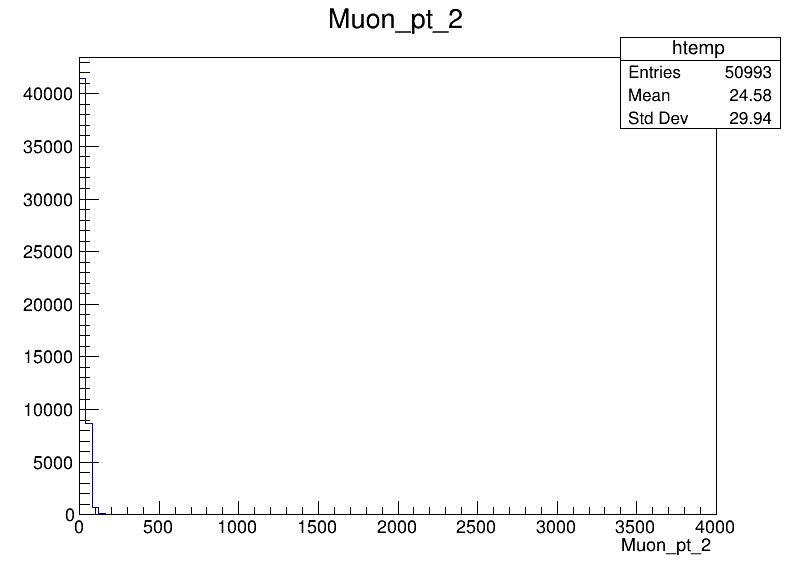

In [9]:
import ROOT
import numpy as np
import pickle
# !pip install xgboost 
# !pip install sklearn 

f_data = ROOT.TFile.Open("train_signal.root", "READ")
tree_data = f_data.Get("Events")

f_data.ls()
f_data.Print()

c1 = ROOT.TCanvas("c1", "Title", 800, 600)
tree_data.Draw("Muon_pt_2")
c1.Draw()

In [3]:
def filter_events(df):
    """
    Reduce initial dataset to only events which shall be used for training
    """
    return df.Filter("nElectron>=2 && nMuon>=2", "At least two electrons and two muons")
 
def define_variables(df):
    """
    Define the variables which shall be used for training
    """
    return df.Define("Muon_pt_1", "Muon_pt[0]")\
             .Define("Muon_pt_2", "Muon_pt[1]")\
             .Define("Electron_pt_1", "Electron_pt[0]")\
             .Define("Electron_pt_2", "Electron_pt[1]")
 
variables = ["Muon_pt_1", "Muon_pt_2", "Electron_pt_1", "Electron_pt_2"]
 
if __name__ == "__main__":
    for filename, label in [["SMHiggsToZZTo4L.root", "signal"], ["ZZTo2e2mu.root", "background"]]:
        print(">>> Extract the training and testing events for {} from the {} dataset.".format(
            label, filename))
 
        # Load dataset, filter the required events and define the training variables
        filepath = "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/" + filename
        df = ROOT.RDataFrame("Events", filepath)
        df = filter_events(df)
        df = define_variables(df)
 
        # Book cutflow report
        report = df.Report()
 
        # Split dataset by event number for training and testing
        columns = ROOT.std.vector["string"](variables)
        df.Filter("event % 2 == 0", "Select events with even event number for training")\
          .Snapshot("Events", "train_" + label + ".root", columns)
        df.Filter("event % 2 == 1", "Select events with odd event number for training")\
          .Snapshot("Events", "test_" + label + ".root", columns)
 
        # Print cutflow report
        report.Print()

>>> Extract the training and testing events for signal from the SMHiggsToZZTo4L.root dataset.
>>> Extract the training and testing events for background from the ZZTo2e2mu.root dataset.
At least two electrons and two muons: pass=45352      all=299973     -- eff=15.12 % cumulative eff=15.12 %
At least two electrons and two muons: pass=262776     all=1497445    -- eff=17.55 % cumulative eff=17.55 %


Plugin No such file or directory loading sec.protocol libXrdSeckrb5-4.so


In [4]:
def load_data(signal_filename, background_filename):
    # Read data from ROOT files
    data_sig = ROOT.RDataFrame("Events", signal_filename).AsNumpy()
    data_bkg = ROOT.RDataFrame("Events", background_filename).AsNumpy()

    # Convert inputs to format readable by machine learning tools
    x_sig = np.vstack([data_sig[var] for var in variables]).T
    x_bkg = np.vstack([data_bkg[var] for var in variables]).T
    x = np.vstack([x_sig, x_bkg])

    # Create labels
    num_sig = x_sig.shape[0]
    num_bkg = x_bkg.shape[0]
    y = np.hstack([np.ones(num_sig), np.zeros(num_bkg)])

    # Compute weights balancing both classes
    num_all = num_sig + num_bkg
    w = np.hstack([np.ones(num_sig) * num_all / num_sig, np.ones(num_bkg) * num_all / num_bkg])

    return x, y, w

if __name__ == "__main__":
    # Load data
    x, y, w = load_data("train_signal.root", "train_background.root")

    # Fit xgboost model
    from xgboost import XGBClassifier
    bdt = XGBClassifier(max_depth=3, n_estimators=500, use_label_encoder=False)
    bdt.fit(x, y, w)

    # Save model in TMVA format
    ROOT.TMVA.Experimental.SaveXGBoost(bdt, "myBDT", "tmva101.root", num_inputs=len(variables))


/usr/local/lib/python3.8/dist-packages/xgboost/core.py:430: FutureWarning: Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[10:22:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


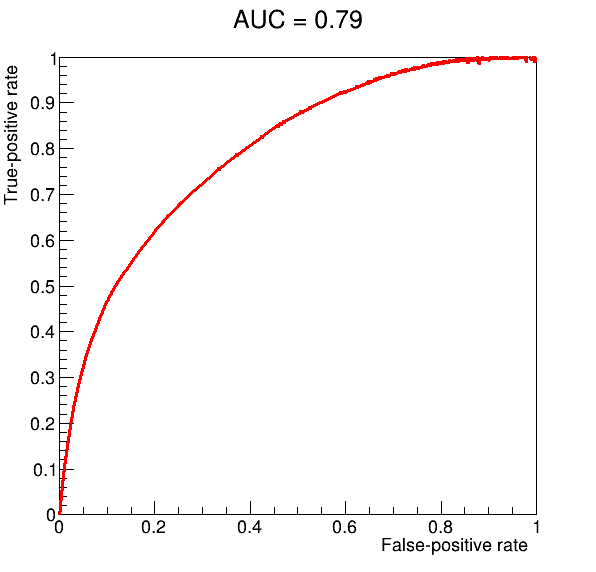

In [5]:
# Load data
x, y_true, w = load_data("test_signal.root", "test_background.root")

# Load trained model
bdt = ROOT.TMVA.Experimental.RBDT[""]("myBDT", "tmva101.root")

# Make prediction
y_pred = bdt.Compute(x)

# Compute ROC using sklearn
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_pred, sample_weight=w)
score = auc(fpr, tpr)

# Plot ROC
c = ROOT.TCanvas("roc", "", 600, 600)
g = ROOT.TGraph(len(fpr), fpr, tpr)
g.SetTitle("AUC = {:.2f}".format(score))
g.SetLineWidth(3)
g.SetLineColor(ROOT.kRed)
g.Draw("AC")
g.GetXaxis().SetRangeUser(0, 1)
g.GetYaxis().SetRangeUser(0, 1)
g.GetXaxis().SetTitle("False-positive rate")
g.GetYaxis().SetTitle("True-positive rate")
c.Draw()